<a href="https://colab.research.google.com/github/SeungYeon2000/pytorch/blob/main/Chap7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# In[1]:
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [20]:
#In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [21]:
#In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [27]:
#In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [28]:
# In[5]:
label_map = {0:0,2:1}
class_names = ['airplane','bird']
cifar2 = [(img,label_map[label])      # cifar2는 Dataset의 기본 필요조건 만족 - __len__ & __getitem__ 정의됨.
          for img, label in cifar10
          if label in [0,2]]
cifar2_val = [(img,label_map[label])
              for img, label in cifar10_val
              if label in [0,2]]

In [29]:
# In[6]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,
                512,        # hidden layer size (임의 설정)
            ),
            nn.Tanh(),
            nn.Linear(
                512,        # hidden layer size
                n_out,
            )
)

In [30]:
# In[7]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [31]:
# In[8]:
x = torch.tensor([1.0,2.0,3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [32]:
# In[9]:
softmax(x).sum()

tensor(1.)

In [33]:
# In[10]:
softmax = nn.Softmax(dim=1)     #차원지정=1

x = torch.tensor ([[1.0,2.0,3.0],
                  [1.0,2.0,3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [34]:
# In[11]:
model = nn.Sequential(
            nn.Linear(3072,512),
            nn.Tanh(),
            nn.Linear(512,2),
            nn.Softmax(dim=1))
# softmax를 model 끝에 추가, 이제 probabilities 생성할 준비 됨.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


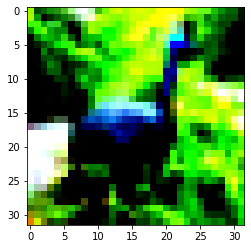

In [35]:
# In[12]:
img, _ = cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [36]:
# In[13]:
img_batch = img.view(-1).unsqueeze(0)       # make right 차원 -> 1D tensor로, 추가 차원을 0번째 자리에 넣어줌.

In [37]:
# In[14]:
out = model(img_batch)
out                       # probabilities (그러나 W,H 훈련 안 된 부정확한 데이터)

tensor([[0.3981, 0.6019]], grad_fn=<SoftmaxBackward>)

loss function 이 있어야 유의미함 (back propagation후에), maximum probability 필요 : torch.max 필요

In [39]:
# In[15]:
_, index = torch.max(out,dim=1)
index
# 결과가 tensor([1])이니까 bird라는 뜻

tensor([1])

# **7.2.5 A loss for classifying**
MSE 사용 X, 대신 잘못된 분류를 줄이기

out[class_index]를 최대화해야 함. -> out : output of softmax / class_index : vector(airplane-0,bird-1 대응)

Negative Log Likelihood(NLL) :
loss function high & 가능성 low
NLL = -sum(log(out_i[c_i])) ; sum - N samples의 합, c_i - sample i 에 대한 정확한 분류

분류에 대한 loss 계산 과정
1. forward pass 작동, last layer에서 결과값 얻기
2. softmax 계산, 확률 얻기
3. 맞는 분류에 해당하는 예측된 확률 취하기.
4. 로그 계산하고 - 붙여서 loss에 추가

nn.Softmax 대신 nn.LogSoftmax 사용

cross entrophy loss >>> MSE loss

In [ ]:
# 결과 모듈로 nn.LogSoftmax 사용하도록 수정하기
# model = nn.Sequential(
#          nn.Linear(3072,512),
#          nn.Tanh(),
#          nn.Linear(512,2),
#          nn.LogSoftmax(dim=1))

In [ ]:
# NLL loss 실행
# loss = nn.NLLLoss()

# **7.2.6 Training the classifier**
일반적으로 minibatches는 우리가 training 전에 설정하는 constant size이고 (learning rate처럼) hyperparameters라고 불린다. (parameters와는 다른 개념)

torch.utils.data module : minibatches(DataLoader)에서 정보를 섞고 조직하도록 함. DataLoader는 dataset에서 minibatches를 sample하고 여러 샘플링 전략을 고르게 함.

nn.LogSoftmax + nn.NLLLoss = nn.CrossEntropyLoss

loss_fn = nn.CrossentropyLoss()를 쓰는 경우가 많음, 간단하니까.

# **7.2.7 The Limits of going fully connected**
output pixel 당 하나의 Weight의 벡터가 있음.

fully connected module (with an input image) 이면 모든 input pixel은 다른 pixel과 결합해 결과에서 각 element를 생성. ntranslation invariant가 아님.